# **Problem 5: RNN as a generative model**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset
import glob 
import pickle
from collections import defaultdict
from torchvision.datasets import MNIST

In [2]:
# This chunck of code is taken from here: https://gist.github.com/y0ast/f69966e308e549f013a92dc66debeeb4
class FastMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Scale data to [0,1]
        self.data = self.data.unsqueeze(1).float().div(255)
        
        # Normalize it with the usual MNIST mean and std
        # self.data = self.data.sub_(0.1307).div_(0.3081)
        
        # Put both data and targets on GPU in advance
        self.data, self.targets = self.data.to(device), self.targets.to(device)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = FastMNIST('data/MNIST', train=True, download=True)
test_dataset = FastMNIST('data/MNIST', train=False, download=True)

# check the shape of the dataset
print("shape before: ") 
print(train_dataset.data.shape, test_dataset.data.shape)

In [4]:
# we will separate train dataset into 2 different dataset for train and test
extra_data, extra_targets = train_dataset.data[len(train_dataset.data) - 10000:, :, :, :], train_dataset.targets[len(train_dataset.data) - 10000:]
train_data, train_targets = train_dataset.data[:len(train_dataset.data)-10000, :, :, :], train_dataset.targets[:len(train_dataset.targets) - 10000] 


print(train_data.shape, train_targets.shape)
print(extra_data.shape, extra_targets.shape)

torch.Size([50000, 1, 28, 28]) torch.Size([50000])
torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [5]:
# convert images to patch of 7x7
mtr = F.unfold(train_data, kernel_size=7, stride=7)
mte = F.unfold(test_dataset.data, kernel_size=7, stride=7)

mtr = mtr.permute(0, 2, 1)
mte = mte.permute(0, 2, 1)

# check the shape of the dataset
print("shape before: ") 
print(mtr.data.shape, mte.data.shape)

shape before: 
torch.Size([50000, 16, 49]) torch.Size([10000, 16, 49])


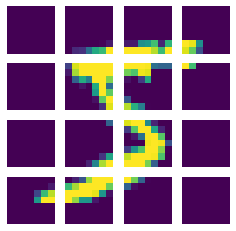

In [6]:
# print patched mnist example
fig,axes = plt.subplots(nrows = 4, ncols = 4, figsize=(4,4))
print_ex = mtr[0]

i = 0
for r in range(4):
    for c in range(4):
      axes[r, c].imshow(print_ex[i].cpu().numpy().reshape(7,7))
      axes[r, c].axis('off')
      i+=1
fig.show()

In [7]:
# creating data loader
trX = mtr[:, :15, :]
trY = mtr[:, 1:, :]
print(trX.is_cuda, trY.is_cuda)

teX = mte[:, :15, :]
teY = mte[:, 1:, :]
print(teX.is_cuda, teY.is_cuda)

train_loader = DataLoader(utils.TensorDataset(trX, trY), batch_size=100, shuffle=True)
test_loader = DataLoader(utils.TensorDataset(teX, teY), batch_size=100, shuffle=False)

# checking the dimension of the data
a, b = next(iter(train_loader))
print(a.shape, b.shape)

True True
True True
torch.Size([100, 15, 49]) torch.Size([100, 15, 49])


In [8]:
# checking the dimension of the data
a, b = next(iter(test_loader))
print(a.shape, b.shape)

torch.Size([100, 15, 49]) torch.Size([100, 15, 49])


In [56]:
# defining the network
# referred this blog to understand hidden state intialization https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

class RNN(nn.Module):
    def __init__(self, inp_size, hid_size, n_layers):
        super(RNN, self).__init__()

        self.inp_size = inp_size
        self.hid_size = hid_size
        self.n_layers = n_layers

        self.lstm  = nn.LSTM(input_size=inp_size, hidden_size=hid_size, num_layers=n_layers, batch_first=True)
        self.fcn = nn.Linear(in_features=hid_size, out_features=inp_size)
    
    def forward(self, x, hidden):
        x, hidden_states = self.lstm(x, hidden)
        fcn_output = torch.sigmoid(self.fcn(x))
        return fcn_output, hidden_states
    
    def init_hidden(self, batch_size=1):
        hidden = (torch.zeros((self.n_layers, batch_size, self.hid_size)).to(device),
                  torch.zeros((self.n_layers, batch_size, self.hid_size)).to(device))
        return hidden

net = RNN(49, 128, 3)
net.to(device)
err_func = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), 1e-4)
print(net)

RNN(
  (lstm): LSTM(49, 128, num_layers=3, batch_first=True)
  (fcn): Linear(in_features=128, out_features=49, bias=True)
)


In [57]:
# training the network
epochs = 400
early_stopping_count = 0
for e in range(1, epochs+1):
    train_loss = 0
    val_loss = 0
    net.train()
    for row, target in train_loader:
        # set the gradients to zero as PyTorch automatically accumulates gradients
        optimizer.zero_grad()

        hidden_state = net.init_hidden(batch_size=100)
        outs, hidden = net(row, hidden_state)

        # calculate loss
        loss = err_func(outs, target)
        
        # Calculate gradients
        loss.backward()
        
        # Propagate gradients back
        optimizer.step()
        
        train_loss += loss.item()
    else:
        net.eval()
        with torch.no_grad():
            for t_row, t_target in test_loader:
                t_hidden_state = net.init_hidden(batch_size=100)
                t_outs, t_hidden = net(t_row, t_hidden_state)
                val_loss += err_func(t_outs, t_target).item()
    val_loss = round(val_loss/len(test_loader),4)
    train_loss = round(train_loss/len(train_loader),4)
    
    if e % 10 == 0:
        print("EPOCH:{eps}  |    train_loss:{tls}    |    val_loss:{vls}".format(eps = e, tls=train_loss, vls=val_loss))
        if val_loss > train_loss:
            early_stopping_count += 1
            if early_stopping_count > 5:
                print("***Early stopping at epoch {eps} with validation loss={vls} and training loss={tls}***".format(eps=e, tls=train_loss, vls=val_loss))
                break

EPOCH:10  |    train_loss:0.0602    |    val_loss:0.0589
EPOCH:20  |    train_loss:0.0457    |    val_loss:0.0448
EPOCH:30  |    train_loss:0.0392    |    val_loss:0.0388
EPOCH:40  |    train_loss:0.036    |    val_loss:0.0357
EPOCH:50  |    train_loss:0.0341    |    val_loss:0.0339
EPOCH:60  |    train_loss:0.0328    |    val_loss:0.0328
EPOCH:70  |    train_loss:0.0319    |    val_loss:0.0319
EPOCH:80  |    train_loss:0.0312    |    val_loss:0.0313
EPOCH:90  |    train_loss:0.0306    |    val_loss:0.0307
EPOCH:100  |    train_loss:0.0301    |    val_loss:0.0304
EPOCH:110  |    train_loss:0.0297    |    val_loss:0.0299
EPOCH:120  |    train_loss:0.0293    |    val_loss:0.0296
EPOCH:130  |    train_loss:0.029    |    val_loss:0.0293
***Early stopping at epoch 130 with validation loss=0.0293 and training loss=0.029***


In [58]:
def converter(image):
    image = F.unfold(image.unsqueeze(dim=0), kernel_size=7, stride=7)
    image = image.permute(0, 2, 1)[:, :15, :]
    return image.squeeze()

def generateSequence(image):
    image = converter(image)
    h0 = net.init_hidden()
    # create a dummy tensor and intialize it with zeroes
    generated = torch.zeros(16, 49)

    # replce data of 8 sequence of image into the dummy
    generated[:8] = image[:8]

    out, h = net(image[:8, :].unsqueeze(dim=0), h0)
    #print(out.shape, h[0].shape, h[1].shape)

    generated[8] = torch.squeeze(out)[-1].cpu().detach()
    out = torch.squeeze(out)[-1:,:]
    out = out.unsqueeze(dim=0)

    for a in range(9, 16, 1):
        out, h = net(out, h)
        generated[a] = torch.squeeze(out).cpu().detach()

    generated = F.fold(generated.unsqueeze(dim=0).permute(0,2,1), output_size=(28,28), kernel_size=7, stride=7)
    return generated.cpu().numpy().squeeze().reshape(28,28)

I am inference on both, samples extracted from test data as well as the extra train data since it was unclear which data is to be used for testing. The source of confusion was contradiction between instruction given in the question and the discussion on the piazza related to this.

#### **Inferencing on 100 samples extracted from test dataset**

In [59]:
# extracting 100 images (10 of each class) for inference from test dataset
image_100_te = []
for n in range(10):
    count = 0
    same_digit_list = []
    for i in range(len(test_dataset.targets)):
        if test_dataset.targets[i] == n:
            same_digit_list.append(test_dataset.data[i])
            count += 1
        if count == 10:
            break
    print("checking lenght of each class: ", len(same_digit_list))
    image_100_te.append(same_digit_list)
print("checking lenght of main list: ", len(image_100_te))

checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of main list:  10


In [60]:
generated_100_te = []
for i in range(10):
    class_list = []
    for j in range(10):
        class_list.append(generateSequence(image_100_te[i][j]))
    generated_100_te.append(class_list)
print("finished generating!")

finished generating!


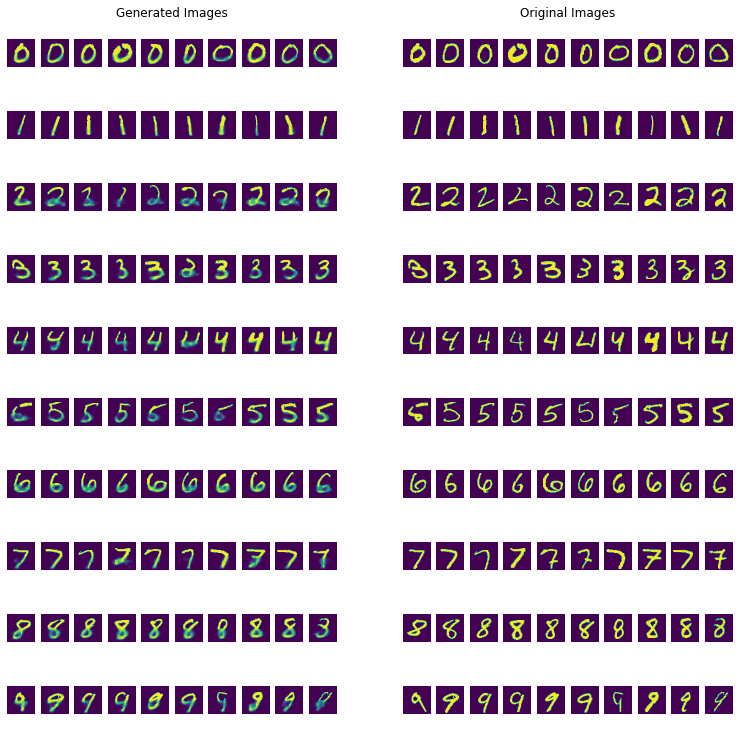

In [61]:
# https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
# https://matplotlib.org/3.1.0/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(13, 13))

spec = gridspec.GridSpec(ncols=2, nrows=1, hspace=10)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax1.set_title("Generated Images")
ax2.set_title("Original Images")
ax1.axis('off')
ax2.axis('off')

left = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[0]) # plot for generated images
right = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[1]) # plot for original images
c = 0 
for j in range(10):
    for k in range(10):
        ax = plt.Subplot(fig, left[c])
        ax.imshow(generated_100_te[j][k])
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        fig.add_subplot(ax)

        ax = plt.Subplot(fig, right[c])
        ax.imshow(image_100_te[j][k].cpu().numpy().reshape(28, 28))
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        fig.add_subplot(ax)
        c += 1
plt.show()

#### **Inferencing on 100 samples extracted from extra train dataset**

In [62]:
# extracting 100 images (10 of each class) for inference from extra train dataset
image_100_ex = []
for n in range(10):
    count = 0
    same_digit_list = []
    for i in range(len(extra_targets)):
        if extra_targets[i] == n:
            same_digit_list.append(extra_data[i])
            count += 1
        if count == 10:
            break
    print("checking lenght of each class: ", len(same_digit_list))
    image_100_ex.append(same_digit_list)
print("checking lenght of main list: ", len(image_100_ex))

checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of each class:  10
checking lenght of main list:  10


In [63]:
generated_100_ex = []
for i in range(10):
    class_list = []
    for j in range(10):
        class_list.append(generateSequence(image_100_ex[i][j]))
    generated_100_ex.append(class_list)
print("finished generating!")

finished generating!


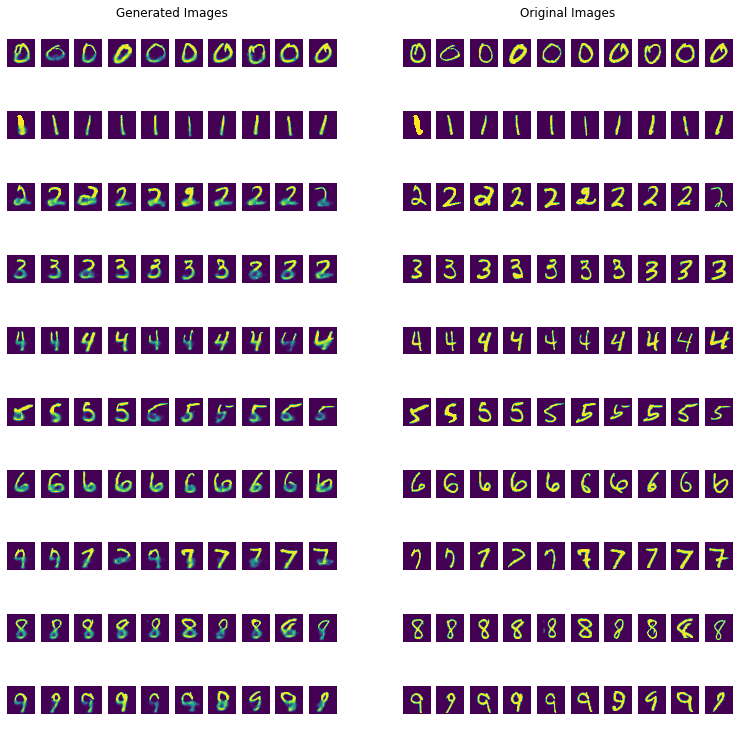

In [64]:
fig = plt.figure(figsize=(13, 13))

spec = gridspec.GridSpec(ncols=2, nrows=1, hspace=10)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax1.set_title("Generated Images")
ax2.set_title("Original Images")
ax1.axis('off')
ax2.axis('off')

left = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[0]) # plot for generated images
right = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[1]) # plot for original images
c = 0 
for j in range(10):
    for k in range(10):
        ax = plt.Subplot(fig, left[c])
        ax.imshow(generated_100_ex[j][k])
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        fig.add_subplot(ax)

        ax = plt.Subplot(fig, right[c])
        ax.imshow(image_100_ex[j][k].cpu().numpy().reshape(28, 28))
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        fig.add_subplot(ax)
        c += 1
plt.show()

As we can see for the above plot, the results are almost similar to what professor Kim is having.